Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
   alpha       c_l       c_d      c_dp       c_m  converged  camber  thickness
0   -5.0 -0.584607  0.018963  0.004905  0.003722        1.0     0.0        9.0
1   -3.0 -0.453449  0.012492  0.002763  0.023578        1.0     0.0        9.0
2   -1.0 -0.018605  0.013619  0.003558 -0.013303        1.0     0.0        9.0
3    1.0  0.018625  0.013617  0.003558  0.013301        1.0     0.0        9.0
4    3.0  0.453421  0.012491  0.002764 -0.023573        1.0     0.0        9.0
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 44
   
___________________________________________________________________________
   
 Training
   
   Training ...


c:\Users\wongj_rl8z6\AppData\Local\Programs\Python\Python311\Lib\site-packages\smt\surrogate_models\krg_based.py:532: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn(


   Training - done. Time (sec):  0.3915994
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009961
   
   Prediction time/pt. (sec) :  0.0000100
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 44
   
   Predicting ...
   Predicting - done. Time (sec):  0.0088387
   
   Prediction time/pt. (sec) :  0.0002009
   


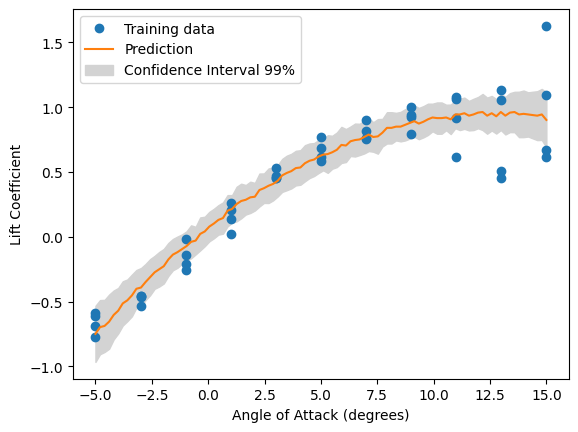

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from smt.surrogate_models import KRG
from juliacall import Main as jl

# from cmplxfoil import CMPLXFOIL


def read_data(file_path):
    data = pd.read_csv(
        file_path, names=["alpha", "c_l", "c_d", "c_dp", "c_m", "converged"]
    )
    print(data.head())
    return data


def create_surrogate(xt, yt):
    sm = KRG(theta0=[1e-2])
    sm.set_training_values(xt, yt)
    sm.train()
    return sm


def plot_surrogate(sm, xt, yt, alpha_min=-5.0, alpha_max=15.0, xlabel="x", ylabel="y"):
    num = 100
    x = np.linspace(alpha_min, alpha_max, num)
    y = sm.predict_values(x)
    # estimated variance
    s2 = sm.predict_variances(x)
    # derivative according to the first variable
    _dydx = sm.predict_derivatives(xt, 0)
    _, axs = plt.subplots(1)

    # add a plot with variance
    axs.plot(xt, yt, "o")
    axs.plot(x, y)
    axs.fill_between(
        np.ravel(x),
        np.ravel(y - 3 * np.sqrt(s2)),
        np.ravel(y + 3 * np.sqrt(s2)),
        color="lightgrey",
    )
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    if ylabel == "Moment Coefficient":
        axs.set_ylim([-0.5, 0.5])
    axs.legend(
        ["Training data", "Prediction", "Confidence Interval 99%"],
        loc="upper left",
    )

    plt.show()


if __name__ == "__main__":
    # Load the Julia file
    jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

    # Call the process_files function
    list_of_files = ["naca0009.dat", "naca0012.dat", "naca0015.dat", "naca0018.dat"]
    alpha = range(-5, 16, 2)  # range of angle of attacks, in degrees
    re = 1e5

    # Convert Python list to Julia array
    julia_list_of_files = jl.convert(jl.Array, list_of_files)
    julia_alpha = jl.convert(jl.Array, alpha)

    # Call the function
    combined_data = jl.process_files(julia_list_of_files, julia_alpha, re)

    # Print the result
    # print(combined_data)

    # filepath = "C:\\Users\\wongj_rl8z6\\FlowLab\XFoil\\xfoil_results.csv"
    # data = read_data(filepath)
    columns = ["alpha", "c_l", "c_d", "c_dp", "c_m", "converged", "camber", "thickness"]
    data = pd.DataFrame(combined_data, columns=columns)
    print(data.head())

    focus = "lift"  # "lift", "drag", or "moment"

    if focus == "lift":
        xt = data["alpha"].values
        yt = data["c_l"].values
        label = "Lift Coefficient"
    elif focus == "drag":
        xt = data["alpha"].values
        yt = data["c_d"].values
        label = "Drag Coefficient"
    elif focus == "moment":
        xt = data["alpha"].values
        yt = data["c_m"].values
        label = "Moment Coefficient"

    alpha_min = min(alpha)
    alpha_max = max(alpha)

    sm = create_surrogate(xt, yt)
    plot_surrogate(sm, xt, yt, xlabel="Angle of Attack (degrees)", ylabel=label)